In [1]:
import pandas as pd
import string
import re
import nltk
import numpy as np
import collections as co
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/lenta-ru-news.csv')

In [3]:
data.head()

,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды
2,https://lenta.ru/news/2018/12/15/disneyland/,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Мир
3,https://lenta.ru/news/2018/12/15/usa25/,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика
4,https://lenta.ru/news/2018/12/15/integrity/,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Общество


In [4]:
data.shape

(739351, 5)

In [5]:
data['tags'].unique()

array(['Общество', 'Зимние виды', 'Мир', 'Политика', 'Украина', 'Coцсети',
       'Следствие и суд', 'Хоккей', 'Деньги', 'Госэкономика',
       'Происшествия', 'Футбол', 'Бизнес', 'Музыка', 'Квартира',
       'Бокс и ММА', 'Театр', 'Оружие', 'Дача', 'Прибалтика', 'Рынки',
       'Звери', 'Техника', 'Интернет', 'Люди', 'Наука', 'Внешний вид',
       'Кино', 'ТВ и радио', 'Регионы', 'Космос', 'Явления', 'Стиль',
       'Белоруссия', 'События', 'Деловой климат', 'Все', 'Искусство',
       'Движение', 'Преступность', 'Криминал', 'Жизнь', 'Мнения',
       'Полиция и спецслужбы', 'Конфликты', 'Авто', 'Книги', 'Вкусы',
       'Фотография', 'Реклама', 'Закавказье', nan, 'Часы', 'Летние виды',
       'Россия', 'Пресса', 'Вещи', 'История', 'Игры', 'Достижения',
       'Офис', 'Средняя Азия', 'Еда', 'Москва', 'Социальная сфера',
       'Молдавия', 'Преступная Россия', 'Гаджеты', 'Город',
       'Киберпреступность', 'Страноведение', 'Софт', 'Инструменты',
       'Вирусные ролики', 'Экология', 'Выб

In [6]:
freq = pd.DataFrame(data['tags'].value_counts())

category_to_drop = ['Украина', 'Происшествия', 'Госэкономика', 'Следствие и суд', 'Преступность',
                    'Регионы', 'Криминал', 'Конфликты', 'Полиция и спецслужбы', 'Молдавия', 'Все',
                    'Общество', 'Политика']

freq_threshold = 1000
category_to_drop.extend(freq[freq['tags'] < freq_threshold].index)

In [7]:
for cat in category_to_drop:
    data = data.drop(data[data['tags'] == cat].index)

In [8]:
data.shape

(142612, 5)

In [9]:
data['tags'].isna().value_counts()

False    116098
True      26514
Name: tags, dtype: int64

In [10]:
data = data.drop(data[data['tags'].isna()].index)

In [11]:
data.shape

(116098, 5)

In [12]:
data['title'] = data['title'].str.replace('\xa0', ' ')
data['title'] = data['title'].str.lower()

In [13]:
df_reviews = data[['title']][:]
df_reviews.columns = ['review']
df_reviews.reset_index(drop = True , inplace = True)
df_reviews.head(2)

,review
0,австрия не представила доказательств вины росс...
1,обнаружено самое счастливое место на планете


In [14]:
list_true_words = []

for i ,row in  df_reviews.iterrows():
    words = []    
    true_words = []    
    
    a_line = row['review']
    
    try:
        words = re.split(' ', a_line)
        true_words = []

        for word in words:
            m = re.search('(\w+)',word)
            if m is not None:
                good_word = m.group(0)
                true_words.append(good_word)       
    except:
        pass
    
    list_true_words.append(true_words)

In [15]:
df_reviews['list_of_words'] = list_true_words

In [16]:
text_analizator_df = df_reviews[:]
text_analizator_df.rename(columns = {'review' : 'sentence'} , inplace = True)
text_analizator_df.head()

,sentence,list_of_words
0,австрия не представила доказательств вины росс...,"[австрия, не, представила, доказательств, вины..."
1,обнаружено самое счастливое место на планете,"[обнаружено, самое, счастливое, место, на, пла..."
2,российскую молодежь предложили обучать духовны...,"[российскую, молодежь, предложили, обучать, ду..."
3,названы регионы россии с самым дорогим и дешев...,"[названы, регионы, россии, с, самым, дорогим, ..."
4,испанские клубы открестились от неймара,"[испанские, клубы, открестились, от, неймара]"


In [17]:
# Лемматизация
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatize_list_of_words(list_of_words):
    res = []
    for word in list_of_words:
        p = morph.parse(word)[0]
        new_word = p.normal_form
        res.append(new_word)
    return res  

text_analizator_df['lemmatize_list_of_words'] = text_analizator_df['list_of_words'].apply(lemmatize_list_of_words)

In [18]:
text_analizator_df.head()

,sentence,list_of_words,lemmatize_list_of_words
0,австрия не представила доказательств вины росс...,"[австрия, не, представила, доказательств, вины...","[австрия, не, представить, доказательство, вин..."
1,обнаружено самое счастливое место на планете,"[обнаружено, самое, счастливое, место, на, пла...","[обнаружить, самый, счастливый, место, на, пла..."
2,российскую молодежь предложили обучать духовны...,"[российскую, молодежь, предложили, обучать, ду...","[российский, молодёжь, предложить, обучать, ду..."
3,названы регионы россии с самым дорогим и дешев...,"[названы, регионы, россии, с, самым, дорогим, ...","[назвать, регион, россия, с, самый, дорогой, и..."
4,испанские клубы открестились от неймара,"[испанские, клубы, открестились, от, неймара]","[испанский, клуб, откреститься, от, неймара]"


In [19]:
text_arrays = np.concatenate(text_analizator_df.lemmatize_list_of_words, axis=0)

In [20]:
#уберем все пустые строки
text_arrays = list( text_arrays)
text_arrays = list(filter(None, text_arrays))

Text(0.5, 1.0, 'Top Words')

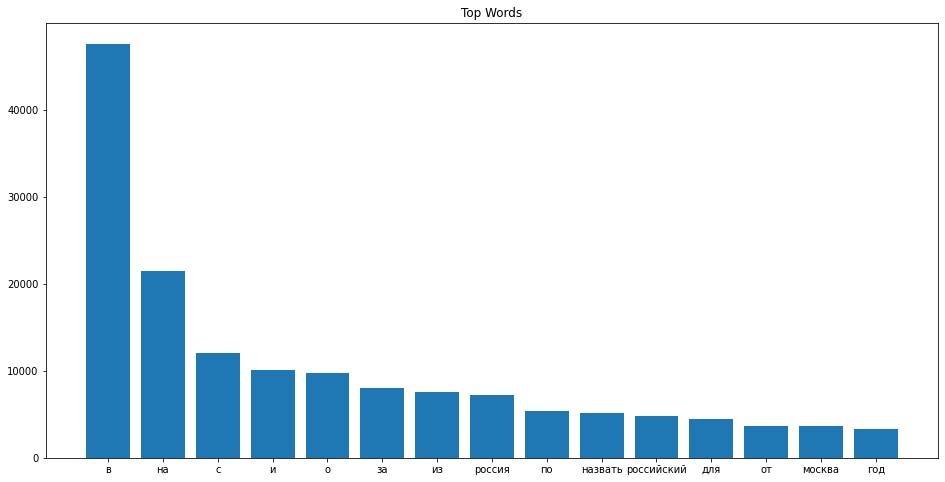

In [21]:
#проанализируем популярные слова
from sklearn.feature_extraction.text import CountVectorizer

c_text = co.Counter(text_arrays)

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(15):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [22]:
top_words = 1500
pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0,ascending = False).head(top_words)

,0
в,47612
на,21524
с,12088
и,10135
о,9719
...,...
снизиться,92
вступиться,92
мощный,91
ленинград,91


In [23]:
#оставим для модели топ  слов
final_words = pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0 , ascending = False).head(top_words).index.values

In [24]:
f = lambda x: ' '.join([item for item in x if item in final_words])
text_analizator_df['lem_text'] = text_analizator_df['lemmatize_list_of_words'].apply(f)

In [25]:
print(f'old- {text_analizator_df.loc[0]["sentence"]}' )
print('\n')
print(f'stem -{text_analizator_df.loc[0]["lem_text"]}' )

old- австрия не представила доказательств вины российских биатлонистов


stem -не представить российский биатлонист


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = text_analizator_df['lem_text']

vec = TfidfVectorizer(max_features=top_words)
tfidf_mat = vec.fit_transform(texts).toarray()
print(type(tfidf_mat),tfidf_mat.shape)

<class 'numpy.ndarray'> (116098, 1483)


In [27]:
train = pd.DataFrame(tfidf_mat)
train['category'] =  data['tags']

target = 'category'
train_columns = list(set(train.columns) - set([target]))

In [28]:
train.dropna(inplace = True)

In [29]:
#переводим в инты таргет
labels, levels = pd.factorize(train[target])
train['category_int'] = labels

target = 'category_int'

In [30]:
levels

Index(['Зимние виды', 'Мир', 'Coцсети', 'Деньги', 'Футбол', 'Бизнес', 'Музыка',
       'Квартира', 'Бокс и ММА', 'Театр', 'Оружие', 'Дача', 'Прибалтика',
       'Рынки', 'Звери', 'Техника', 'Интернет', 'Люди', 'Наука', 'Кино',
       'ТВ и радио', 'Космос', 'Явления', 'Стиль', 'События', 'Деловой климат',
       'Искусство', 'Книги', 'Закавказье', 'Летние виды', 'Пресса', 'Игры',
       'Средняя Азия', 'Москва', 'Гаджеты', 'Город'],
      dtype='object')

rate target detect fight in game 17.5


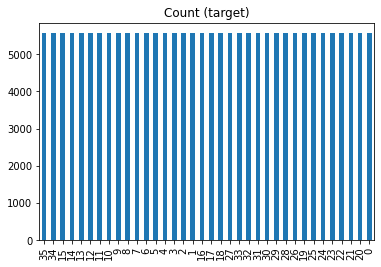

In [31]:
#сделаем оверсемплинг

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train[train_columns], train[target])

print(f'rate target detect fight in game {sum(y_ros) / X_ros.shape[0]}')

y_ros.value_counts().plot(kind='bar', title='Count (target)');

In [32]:
X_ros[target] = y_ros
train = X_ros[:]

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train[train_columns]
                                                    , train[target] 
                                                    , test_size=0.2
                                                    , stratify = train[target] 
                                                   )

In [34]:
text_classifier = MLPClassifier(hidden_layer_sizes = (16, 4), max_iter = 200, random_state = 40,
                                activation = 'relu')

In [38]:
# model = text_classifier.fit(x_train, y_train)
import pickle
with open("./models/new_mlp_model.pkl", 'rb') as file:
    model = pickle.load(file)

In [37]:
predicts = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.08      0.09      0.08      1115
           1       0.00      0.00      0.00      1115
           2       0.06      0.02      0.03      1115
           3       0.79      0.84      0.81      1115
           4       0.00      0.00      0.00      1115
           5       0.00      0.00      0.00      1115
           6       0.00      0.00      0.00      1115
           7       0.00      0.00      0.00      1115
           8       0.04      0.00      0.01      1115
           9       0.49      0.89      0.64      1115
          10       0.10      0.21      0.14      1115
          11       0.71      0.84      0.77      1115
          12       0.85      0.93      0.89      1115
          13       0.30      0.69      0.42      1115
          14       0.05      0.02      0.02      1115
          15       0.71      0.86      0.78      1115
          16       0.00      0.00      0.00      1115
          17       0.05    

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
message = 'читать редакция'
prediction = model.predict_proba(vec.transform([message]).toarray())

In [66]:
print(prediction.max())
print(prediction.argmax())
print(levels[prediction.argmax()])

0.09577549321814127
33
Москва


In [ ]:
# import pickle
# pkl_filename = "models/new_mlp_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
# pickle.dump(vec, open("models/tfidf.pickle", "wb"))